<a href="https://colab.research.google.com/github/Neal006/transaction-fraud-detection-system/blob/master/ssl_roboticarm_anomalydetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torch pytorch-lightning tslearn umap-learn faiss-cpu scikit-learn pandas matplotlib seaborn
import torch, torch.nn as nn
import pytorch_lightning as pl
import pandas as pd, numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.metrics import classification_report, roc_auc_score
print("installed all the dependencies")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 832.4/832.4 kB 53.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 389.9/389.9 kB 34.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 58.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 61.1 MB/s eta 0:00:00
installed all the dependencies


In [ ]:
NICLA_PATH = "/content/drive/MyDrive/casper_project/dataset/nicla.csv"

nicla = pd.read_csv(
    NICLA_PATH,
    on_bad_lines="warn",
    skiprows=6,
    names=["AccX", "AccY", "AccZ", "GyroX", "GyroY", "GyroZ", "MagX", "MagY", "MagZ"],
)

# Check if there are any empty/Nan variables.
if nicla.isnull().values.any():
    raise ValueError("Nan variable is present.")

# Explore the dataframe.
print(nicla.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1751682 entries, 0 to 1751681
Data columns (total 9 columns):
 #   Column  Dtype  
---  ------  -----  
 0   AccX    float64
 1   AccY    float64
 2   AccZ    float64
 3   GyroX   float64
 4   GyroY   float64
 5   GyroZ   float64
 6   MagX    float64
 7   MagY    float64
 8   MagZ    float64
dtypes: float64(9)
memory usage: 120.3 MB
None


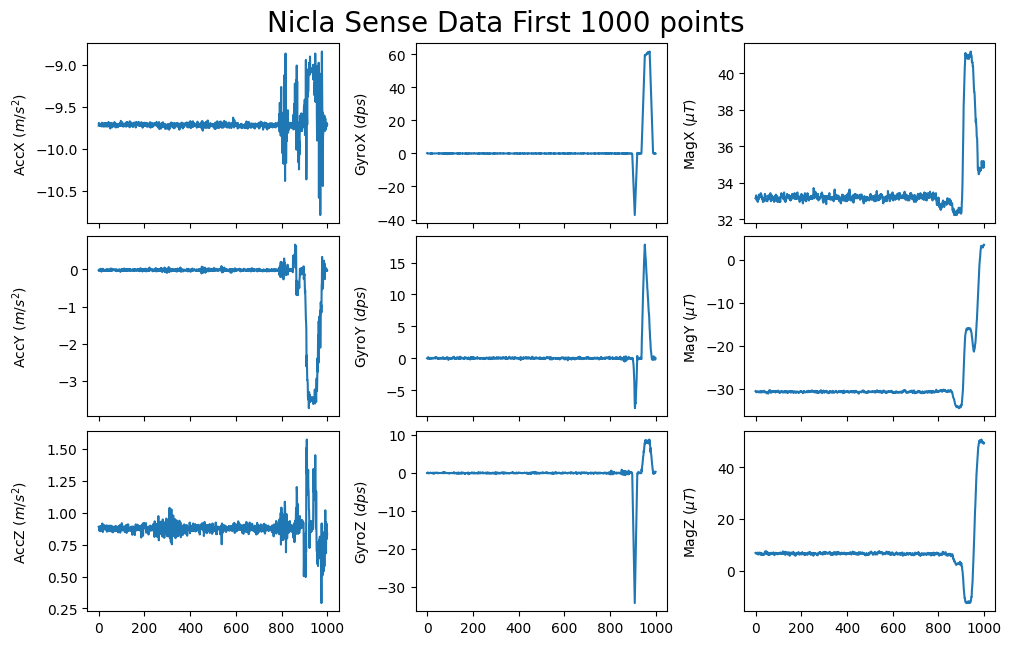

In [ ]:
import matplotlib.pyplot as plt


fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(
    3, 3, sharex=True, figsize=(10, 6), constrained_layout=True
)

START_INDEX = 0
END_INDEX = 1000

ax1.plot(nicla.index[START_INDEX:END_INDEX], nicla["AccX"][START_INDEX:END_INDEX])
ax1.set_ylabel(r"AccX $(m/s^2)$")

ax2.plot(nicla.index[START_INDEX:END_INDEX], nicla["GyroX"][START_INDEX:END_INDEX])
ax2.set_ylabel(r"GyroX $(dps)$")

ax3.plot(nicla.index[START_INDEX:END_INDEX], nicla["MagX"][START_INDEX:END_INDEX])
ax3.set_ylabel(r"MagX (${\mu}T$)")

ax4.plot(nicla.index[START_INDEX:END_INDEX], nicla["AccY"][START_INDEX:END_INDEX])
ax4.set_ylabel(r"AccY $(m/s^2)$")

ax5.plot(nicla.index[START_INDEX:END_INDEX], nicla["GyroY"][START_INDEX:END_INDEX])
ax5.set_ylabel(r"GyroY $(dps)$")

ax6.plot(nicla.index[START_INDEX:END_INDEX], nicla["MagY"][START_INDEX:END_INDEX])
ax6.set_ylabel(r"MagY (${\mu}T$)")

ax7.plot(nicla.index[START_INDEX:END_INDEX], nicla["AccZ"][START_INDEX:END_INDEX])
ax7.set_ylabel(r"AccZ $(m/s^2)$")

ax8.plot(nicla.index[START_INDEX:END_INDEX], nicla["GyroZ"][START_INDEX:END_INDEX])
ax8.set_ylabel(r"GyroZ $(dps)$")

ax9.plot(nicla.index[START_INDEX:END_INDEX], nicla["MagZ"][START_INDEX:END_INDEX])
ax9.set_ylabel(r"MagZ (${\mu}T$)")

fig.align_labels()
plt.suptitle("Nicla Sense Data First 1000 points", x=0.5, y=1.05, fontsize=20)
plt.show()

In [ ]:
index = np.argmax(nicla["GyroX"][:1000].diff().abs() >= 1)
index

np.int64(898)

In [ ]:
# Drop the first 898 points
nicla_dropped = nicla.iloc[897:]
# Reset the index.
nicla_dropped.index = pd.RangeIndex(len(nicla_dropped.index))

In [ ]:
RIGHT = "/content/drive/MyDrive/casper_project/dataset/right_arm.csv"

right_arm = pd.read_csv(RIGHT, on_bad_lines="warn")

# Reset Timestamp to 0.
right_arm["Timestamp"] = right_arm["Timestamp"] - right_arm["Timestamp"][0]

In [ ]:
# Get the length of nicla and the other one.
len_nicla_dropped = len(nicla_dropped)
len_right_arm = len(right_arm)

print(f"The length of the right arm data is {len_right_arm}")
print(f"The length of the nicla data is {len_nicla_dropped}")

The length of the right arm data is 1762650
The length of the nicla data is 1750785


In [ ]:
# Find the final 1.
df_labels = right_arm["Anomaly State"]
index_list = np.where(df_labels == 1)
index_of_last_one = index_list[0][-1]
print(f"The final 1 is located at: {index_of_last_one}")

The final 1 is located at: 1728006


In [ ]:
right_arm = right_arm[0:1728006]
nicla_dropped = nicla_dropped[0:1728006]
n = len(nicla_dropped)
n_arm = len(right_arm)
print(f"The length of Nicla data is {n}")
print(f"The length of arm data is {n_arm}")

The length of Nicla data is 1728006
The length of arm data is 1728006


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.utils.data import Dataset, DataLoader


In [ ]:
def get_normalized(df, x_min, x_max, train_per, val_per):
    """
    Normalize dataframe with MinMaxScaler and split into train/val/test.
    """
    df_len = len(df)
    train_df = df[0:int(df_len * train_per)]
    val_df = df[int(df_len * train_per):int(df_len * (train_per + val_per))]
    test_df = df[int(df_len * (train_per + val_per)):]

    scaler = MinMaxScaler(feature_range=(x_min, x_max))
    scaler.fit(train_df)

    train_norm = pd.DataFrame(scaler.transform(train_df), columns=df.columns)
    val_norm = pd.DataFrame(scaler.transform(val_df), columns=df.columns)
    test_norm = pd.DataFrame(scaler.transform(test_df), columns=df.columns)

    return train_norm, val_norm, test_norm, scaler

X_MIN, X_MAX = 0, 1
TRAIN_RAT, VAL_RAT = 0.6, 0.2
df_train, df_val, df_test, scaler = get_normalized(nicla_dropped, X_MIN, X_MAX, TRAIN_RAT, VAL_RAT)

print("Train/Val/Test shapes:", df_train.shape, df_val.shape, df_test.shape)


Train/Val/Test shapes: (1036803, 9) (345601, 9) (345602, 9)


In [ ]:
def fast_autocorr(x):
    """Compute autocorrelation via FFT (O(n log n)) instead of rolling."""
    x = np.asarray(x)
    x = x - np.mean(x)
    f = np.fft.fft(x, n=2*len(x))
    acf = np.fft.ifft(f * np.conjugate(f)).real
    acf = acf[:len(x)]
    acf /= acf[0]  # Normalize
    return acf

def find_best_window_fast(df, window_min, window_max, sample_size=50000):
    # Find best window size using FFT-based autocorr.
    best = {}

    df_sample = df.iloc[:sample_size]
    for col in df_sample.columns:
        acf = fast_autocorr(df_sample[col].values)

        search_range = acf[window_min:window_max+1]
        best_corr = np.max(search_range)
        best_w = np.argmax(search_range) + window_min
        best[col] = (best_corr, best_w)
    return best

best_windows = find_best_window_fast(df_train, 200, 800, sample_size=50000)
print("Best windows (FFT method):", best_windows)

# Pick median of best windows
input_window = int(np.median([w for _, w in best_windows.values()]))
print("Chosen input window length:", input_window)


Best windows (FFT method): {'AccX': (np.float64(0.5132671695138454), np.int64(755)), 'AccY': (np.float64(0.9648696097381477), np.int64(755)), 'AccZ': (np.float64(0.4587882190666783), np.int64(755)), 'GyroX': (np.float64(0.9815658916907612), np.int64(755)), 'GyroY': (np.float64(0.9786533790398524), np.int64(755)), 'GyroZ': (np.float64(0.9742880283502036), np.int64(755)), 'MagX': (np.float64(0.9794690271460588), np.int64(755)), 'MagY': (np.float64(0.9846575232940366), np.int64(755)), 'MagZ': (np.float64(0.9834564104746434), np.int64(755))}
Chosen input window length: 755


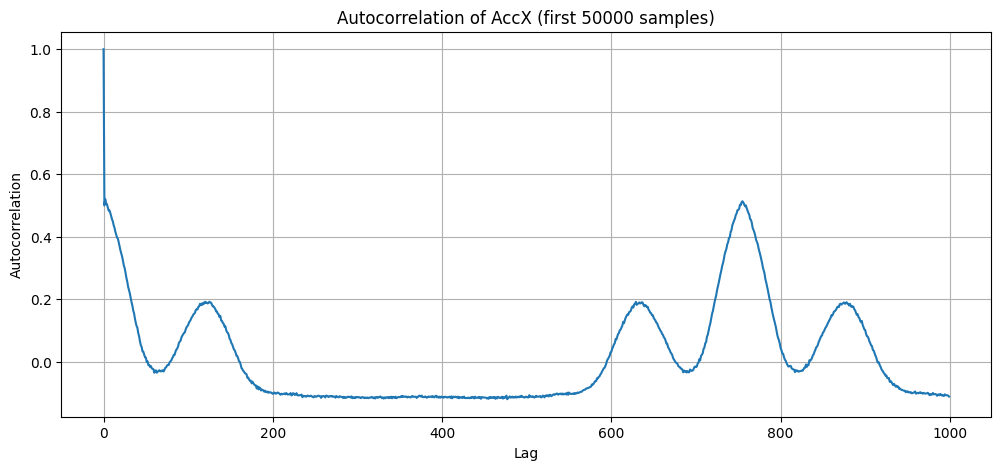

In [ ]:
import matplotlib.pyplot as plt

def plot_autocorr(df, col, max_lag=1000, sample_size=50000):
    """
    Plot autocorrelation for a single column up to max_lag.
    Uses FFT-based autocorr for speed.
    """
    series = df[col].iloc[:sample_size].values
    acf = fast_autocorr(series)

    plt.figure(figsize=(12, 5))
    plt.plot(range(max_lag), acf[:max_lag], lw=1.5)
    plt.title(f"Autocorrelation of {col} (first {sample_size} samples)")
    plt.xlabel("Lag")
    plt.ylabel("Autocorrelation")
    plt.grid(True)
    plt.show()

# Example: plot autocorr for accelerometer X-axis
plot_autocorr(df_train, df_train.columns[0], max_lag=1000)


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

class TimeSeriesWindowDataset(Dataset):

    def __init__(self, df, window_size, stride=10, target_col=None, device="cpu"):
        """
        Args:
            df (pd.DataFrame): Multivariate time series.
            window_size (int): Length of each input window.
            stride (int): Step size between windows (default=10 for speed).
            target_col (str): If provided, returns (X, y) where y = next step of this col.
                              If None → returns only X (self-supervised).
            device (str): "cpu" or "cuda".
        """
        self.data = torch.tensor(df.values, dtype=torch.float32, device=device)
        self.window_size = window_size
        self.stride = stride
        self.target_col = target_col

        # Number of valid windows
        self.num_samples = (len(self.data) - window_size) // stride + 1
        if self.num_samples <= 0:
            raise ValueError("Window size larger than dataset length!")

        self.target_idx = df.columns.get_loc(target_col) if target_col else None

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        start = idx * self.stride
        end = start + self.window_size
        X = self.data[start:end]  # shape: (window_size, num_features)

        if self.target_col is None:
            return X
        else:
            y = self.data[end, self.target_idx] if end < len(self.data) else torch.nan
            return X, y


input_window = 755

dataset = TimeSeriesWindowDataset(df_train, window_size=input_window, stride=10, target_col=None)

print("Number of windows:", len(dataset))
print("Shape of one window:", dataset[0].shape)

loader = DataLoader(dataset, batch_size=32, shuffle=True)

batch = next(iter(loader))
print("Batch shape:", batch.shape)  # (batch_size, window_size, num_features)


Number of windows: 103605
Shape of one window: torch.Size([755, 9])
Batch shape: torch.Size([32, 755, 9])


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

class AugmentedTimeSeriesWindowDataset(Dataset):

    def __init__(self, df, window_size, stride=10, device="cpu",
                 jitter_std=0.01, masking_ratio=0.1, time_warp_max=0.1):
        """
        Args:
            df (pd.DataFrame): Input multivariate time series
            window_size (int): Length of each sliding window
            stride (int): Step size between windows
            device (str): "cpu" or "cuda"
            jitter_std (float): Gaussian noise std
            masking_ratio (float): Fraction of window to mask
            time_warp_max (float): Max fraction to warp time axis
        """
        self.data = torch.tensor(df.values, dtype=torch.float32, device=device)
        self.window_size = window_size
        self.stride = stride
        self.num_samples = (len(self.data) - window_size) // stride + 1
        self.jitter_std = jitter_std
        self.masking_ratio = masking_ratio
        self.time_warp_max = time_warp_max

        if self.num_samples <= 0:
            raise ValueError("Window size larger than dataset length!")

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        start = idx * self.stride
        end = start + self.window_size
        X = self.data[start:end]  # shape: (window_size, num_features)

        view1 = self.augment(X)
        view2 = self.augment(X)
        return view1, view2

    def augment(self, X):
        """Apply jitter, masking, and fast index-based time warping"""
        X_aug = X.clone()

        # 1. Jittering (add Gaussian noise)
        noise = torch.randn_like(X_aug) * self.jitter_std
        X_aug += noise

        # 2. Random masking (mask continuous chunk)
        mask_len = int(self.window_size * self.masking_ratio)
        if mask_len > 0:
            start_mask = np.random.randint(0, self.window_size - mask_len)
            X_aug[start_mask:start_mask+mask_len] = 0.0

        # 3. Time warping (fast index-based approximation)
        warp_factor = 1.0 + np.random.uniform(-self.time_warp_max, self.time_warp_max)
        orig_indices = torch.arange(self.window_size, dtype=torch.float32, device=X_aug.device)
        warped_indices_float = torch.clamp(orig_indices * warp_factor, 0, self.window_size - 1)
        warped_indices = warped_indices_float.long()  # convert to integer for indexing
        X_aug = X_aug[warped_indices]

        return X_aug

input_window = 755
device = "cuda" if torch.cuda.is_available() else "cpu"

aug_dataset = AugmentedTimeSeriesWindowDataset(df_train, window_size=input_window, stride=10, device=device)

batch_size = 64

try:
    aug_loader = DataLoader(aug_dataset, batch_size=batch_size, shuffle=True)
    view1, view2 = next(iter(aug_loader))
    print(f"View1 shape: {view1.shape}, View2 shape: {view2.shape}")
except RuntimeError as e:
    print(f"⚠️ GPU memory error with batch_size={batch_size}: {e}")
    print("Try reducing batch_size to 32 or 16.")

View1 shape: torch.Size([64, 755, 9]), View2 shape: torch.Size([64, 755, 9])


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import copy
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)


Using device: cuda


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import copy

# Residual Block for TS2Vec
class ResidualBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=5, dilation=1):
        super().__init__()
        padding = (kernel_size - 1) // 2 * dilation
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, padding=padding, dilation=dilation)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, padding=padding, dilation=dilation)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.residual = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()

    def forward(self, x):
        res = self.residual(x)
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        return self.relu(x + res)

# TS2Vec Backbone
class TS2VecBackbone(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_layers=3, kernel_size=5):
        super().__init__()
        layers = []
        in_channels = input_dim
        for _ in range(num_layers):
            layers.append(ResidualBlock1D(in_channels, hidden_dim, kernel_size))
            in_channels = hidden_dim
        self.encoder = nn.Sequential(*layers)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.out_dim = hidden_dim

    def forward(self, x):
        x = x.permute(0, 2, 1) # (batch, features, window_size)
        x = self.encoder(x)
        x = self.pool(x).squeeze(-1)
        return x

# DINO Wrapper
class DINO_TS2Vec(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, proj_dim=64, teacher_momentum=0.99):
        super().__init__()
        self.student = TS2VecBackbone(input_dim, hidden_dim)
        self.teacher = copy.deepcopy(self.student)
        self.proj_student = nn.Linear(self.student.out_dim, proj_dim)
        self.proj_teacher = nn.Linear(self.teacher.out_dim, proj_dim)
        self.teacher.requires_grad_(False)
        self.teacher_momentum = teacher_momentum

    @torch.no_grad()
    def update_teacher(self):
        for s_param, t_param in zip(self.student.parameters(), self.teacher.parameters()):
            t_param.data = self.teacher_momentum * t_param.data + (1 - self.teacher_momentum) * s_param.data
        for s_param, t_param in zip(self.proj_student.parameters(), self.proj_teacher.parameters()):
            t_param.data = self.teacher_momentum * t_param.data + (1 - self.teacher_momentum) * s_param.data

    def forward(self, x1, x2):
        z1 = self.proj_student(self.student(x1))
        z2 = self.proj_student(self.student(x2))
        with torch.no_grad():
            t1 = self.proj_teacher(self.teacher(x1))
            t2 = self.proj_teacher(self.teacher(x2))
        return z1, z2, t1.detach(), t2.detach()


In [ ]:
def dino_loss(student_out, teacher_out, tau=0.1):
    # L2 normalize
    student_out = F.normalize(student_out, dim=-1)
    teacher_out = F.normalize(teacher_out, dim=-1)
    # InfoNCE-style cross-entropy
    logits = student_out @ teacher_out.T / tau
    labels = torch.arange(student_out.shape[0], device=student_out.device)
    return F.cross_entropy(logits, labels)


In [ ]:
from torch.utils.data import DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
input_dim = df_train.shape[1]  # number of features
proj_dim = 64
hidden_dim = 128
batch_size = 32
epochs = 20

model = DINO_TS2Vec(input_dim=input_dim, hidden_dim=hidden_dim, proj_dim=proj_dim).to(device)
print("model initialized")

optimizer = torch.optim.AdamW(model.student.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
print("optimizer and scheduler declared")

scaler = torch.cuda.amp.GradScaler()
aug_loader = DataLoader(aug_dataset, batch_size=batch_size, shuffle=True)
print("scaler and aug_loader done")

for ep in range(epochs):
    model.train()
    total_loss = 0
    for x1, x2 in aug_loader:
        x1, x2 = x1.to(device), x2.to(device)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            z1, z2, t1, t2 = model(x1, x2)
            loss = dino_loss(z1, t2) + dino_loss(z2, t1)
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.student.parameters(), 1.5)  # Grad clipping
        scaler.step(optimizer)
        scaler.update()
        model.update_teacher()
        total_loss += loss.item()
    scheduler.step()
    print(f"Epoch {ep+1}/{epochs} - Loss: {total_loss/len(aug_loader):.4f}")


cuda
model initialized
optimizer and scheduler declared
scaler and aug_loader done


/tmp/ipython-input-1566197116.py:18: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/tmp/ipython-input-1566197116.py:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1/20 - Loss: 2.0128
Epoch 2/20 - Loss: 0.3372
Epoch 3/20 - Loss: 0.1687
Epoch 4/20 - Loss: 0.1153
Epoch 5/20 - Loss: 0.0882
Epoch 6/20 - Loss: 0.0728
Epoch 7/20 - Loss: 0.0622
Epoch 8/20 - Loss: 0.0555
Epoch 9/20 - Loss: 0.0503


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.student.eval()  # set backbone to eval mode

def get_dual_view_embeddings(dataset, model, batch_size=32):

    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    all_emb1, all_emb2 = [], []
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.eval()

    with torch.no_grad():
        for batch in loader:
            x1, x2 = batch
            x1, x2 = x1.to(device), x2.to(device)

            emb1 = model.student(x1)
            emb2 = model.student(x2)

            all_emb1.append(emb1.cpu())
            all_emb2.append(emb2.cpu())

    # Concatenate all batches
    embeddings_view1 = torch.cat(all_emb1, dim=0)
    embeddings_view2 = torch.cat(all_emb2, dim=0)
    return embeddings_view1, embeddings_view2

emb_view1, emb_view2 = get_dual_view_embeddings(aug_dataset, model, batch_size=32)
print("View1 embeddings shape:", emb_view1.shape)
print("View2 embeddings shape:", emb_view2.shape)


In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"

# Average dual-view embeddings
embeddings = (emb_view1 + emb_view2) / 2
embeddings = embeddings.float()

# Labels (truncate to embeddings length)
labels = torch.tensor(right_arm["Anomaly State"].values[:len(embeddings)], dtype=torch.long)

# Dataset & DataLoader
dataset = TensorDataset(embeddings, labels)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

print("Dataset prepared. Embeddings shape:", embeddings.shape)


In [ ]:
#MLP Autoencoder
import torch.nn as nn

class MLP_AE(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out

mlp_ae = MLP_AE(embeddings.shape[1]).to(device)
optimizer_ae = torch.optim.Adam(mlp_ae.parameters(), lr=1e-3)
criterion_ae = nn.MSELoss()


In [ ]:
#train MLP Autoencoder
mlp_ae.train()
epochs = 10

for ep in range(epochs):
    total_loss = 0
    for x, _ in loader:
        x = x.to(device)
        optimizer_ae.zero_grad()
        recon = mlp_ae(x)
        loss = criterion_ae(recon, x)
        loss.backward()
        optimizer_ae.step()
        total_loss += loss.item()
    print(f"MLP-AE Epoch {ep+1}/{epochs} - Loss: {total_loss/len(loader):.4f}")

In [ ]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, latent_dim=32):
        super().__init__()
        # Encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        # Decoder
        self.fc2 = nn.Linear(latent_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h = torch.relu(self.fc1(x))
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h = torch.relu(self.fc2(z))
        return self.fc3(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

vae = VAE(embeddings.shape[1]).to(device)
optimizer_vae = torch.optim.Adam(vae.parameters(), lr=1e-3)


In [ ]:
def vae_loss(recon_x, x, mu, logvar):
    BCE = nn.MSELoss()(recon_x, x)
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

vae.train()
epochs = 10

for ep in range(epochs):
    total_loss = 0
    for x, _ in loader:
        x = x.to(device)
        optimizer_vae.zero_grad()
        recon, mu, logvar = vae(x)
        loss = vae_loss(recon, x, mu, logvar)
        loss.backward()
        optimizer_vae.step()
        total_loss += loss.item()
    print(f"VAE Epoch {ep+1}/{epochs} - Loss: {total_loss/len(loader):.4f}")


In [ ]:
class CNN_AE(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(16, 8, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(8, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(16, 1, kernel_size=3, padding=1)
        )

    def forward(self, x):
        x = x.unsqueeze(1)  # (batch, 1, features)
        z = self.encoder(x)
        out = self.decoder(z)
        return out.squeeze(1)

cnn_ae = CNN_AE(embeddings.shape[1]).to(device)
optimizer_cnn = torch.optim.Adam(cnn_ae.parameters(), lr=1e-3)
criterion_cnn = nn.MSELoss()


In [ ]:
cnn_ae.train()
epochs = 10

for ep in range(epochs):
    total_loss = 0
    for x, _ in loader:
        x = x.to(device)
        optimizer_cnn.zero_grad()
        recon = cnn_ae(x)
        loss = criterion_cnn(recon, x)
        loss.backward()
        optimizer_cnn.step()
        total_loss += loss.item()
    print(f"CNN-AE Epoch {ep+1}/{epochs} - Loss: {total_loss/len(loader):.4f}")


In [ ]:
class LSTM_AE(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super().__init__()
        self.encoder = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.decoder = nn.LSTM(hidden_dim, input_dim, batch_first=True)

    def forward(self, x):
        x_seq = x.unsqueeze(1)  # (batch, seq_len=1, features)
        _, (h, _) = self.encoder(x_seq)
        dec_out, _ = self.decoder(h.repeat(1, 1, 1))
        return dec_out.squeeze(1)

lstm_ae = LSTM_AE(embeddings.shape[1]).to(device)
optimizer_lstm = torch.optim.Adam(lstm_ae.parameters(), lr=1e-3)
criterion_lstm = nn.MSELoss()


In [ ]:
lstm_ae.train()
epochs = 10

for ep in range(epochs):
    total_loss = 0
    for x, _ in loader:
        x = x.to(device)
        optimizer_lstm.zero_grad()
        recon = lstm_ae(x)
        loss = criterion_lstm(recon, x)
        loss.backward()
        optimizer_lstm.step()
        total_loss += loss.item()
    print(f"LSTM-AE Epoch {ep+1}/{epochs} - Loss: {total_loss/len(loader):.4f}")


In [ ]:
class MLP_Classifier(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )

    def forward(self, x):
        return self.net(x)

mlp_clf = MLP_Classifier(embeddings.shape[1]).to(device)
optimizer_clf = torch.optim.Adam(mlp_clf.parameters(), lr=1e-3)
criterion_clf = nn.CrossEntropyLoss()


In [ ]:
mlp_clf.train()
epochs = 10

for ep in range(epochs):
    total_loss = 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer_clf.zero_grad()
        out = mlp_clf(x)
        loss = criterion_clf(out, y)
        loss.backward()
        optimizer_clf.step()
        total_loss += loss.item()
    print(f"MLP Classifier Epoch {ep+1}/{epochs} - Loss: {total_loss/len(loader):.4f}")


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

def get_preds_ae(model, X_tensor, threshold=None):
    model.eval()
    with torch.no_grad():
        if isinstance(model, (CNN_AE, LSTM_AE)):
            recon = model(X_tensor.to(device))
        else:
            recon = model(X_tensor.to(device))
        errors = ((recon.cpu() - X_tensor) ** 2).mean(dim=1).numpy()
    if threshold is None:
        threshold = errors[labels_tensor==0].mean() + 3 * errors[labels_tensor==0].std()
    return (errors > threshold).astype(int)

# Autoencoders
mlp_ae_preds = get_preds_ae(mlp_ae, embeddings)
vae_preds = get_preds_ae(vae, embeddings)
cnn_ae_preds = get_preds_ae(cnn_ae, embeddings)
lstm_ae_preds = get_preds_ae(lstm_ae, embeddings)

# Classifier
mlp_clf.eval()
with torch.no_grad():
    logits = mlp_clf(embeddings.to(device))
    mlp_clf_preds = torch.argmax(logits, dim=1).cpu().numpy()

# Compile results
results = {
    "MLP-AE": mlp_ae_preds,
    "VAE": vae_preds,
    "CNN-AE": cnn_ae_preds,
    "LSTM-AE": lstm_ae_preds,
    "MLP-Classifier": mlp_clf_preds
}

metrics = []
for name, pred in results.items():
    acc = accuracy_score(labels, pred)
    f1 = f1_score(labels, pred)
    auc = roc_auc_score(labels, pred)
    metrics.append([name, acc, f1, auc])

import pandas as pd
df_metrics = pd.DataFrame(metrics, columns=["Algorithm", "Accuracy", "F1-Score", "ROC-AUC"])
print(df_metrics)